## TP6 -- Analyse 

In [1]:
import os
import umap
import h5py
import random
import sklearn
import datetime 
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from scipy.stats import pearsonr # Pearson cor

# Custom
import common.plotting
import common.dataprocessing

### Partie 1 

#### Importation des données

In [27]:
inf = "../data/TP6/TCGA_BRCA_fpkm_hv_norm_PAM50.h5"
dataset = h5py.File(inf)

In [28]:
# Extraires les différentes variables du jeux de données
brca_data = dataset["data"][:,:]
labels = np.array(dataset["labels"][:], dtype = str)
samples = np.array(dataset["samples"][:], dtype = str)
genes = np.array(dataset["genes"][:], dtype = str) # Type de tissus dans TCGA
print(brca_data.shape)

(11802, 1023)


#### Visualisation avec UMAP

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(brca_data.T, labels, test_size = 0.2)
#print(X_train)
print(X_train.shape)

(818, 11802)


In [33]:
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =20, n_epochs = 1000).fit(X_train) 
X_tr_umap = mapper.transform(X_train) # Rajouter un transform pour les X_test --> Voir code TP4
print(X_tr_umap.shape)
#print(X_tr_umap)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=20, verbose=1)
Thu Nov 30 16:01:40 2023 Construct fuzzy simplicial set
Thu Nov 30 16:01:42 2023 Finding Nearest Neighbors
Thu Nov 30 16:01:42 2023 Finished Nearest Neighbor Search
Thu Nov 30 16:01:42 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Thu Nov 30 16:01:46 2023 Finished embedding
(818, 2)


In [34]:
# Processing des données
targets = np.unique(labels)
count_df = pd.DataFrame(brca_data).T
labels_df = pd.DataFrame(labels)

count_df["labels"] = labels

print(count_df["labels"])

0         LumB
1         Her2
2         LumB
3       Normal
4       Normal
         ...  
1018      LumA
1019    Normal
1020    Normal
1021    Normal
1022      LumB
Name: labels, Length: 1023, dtype: object


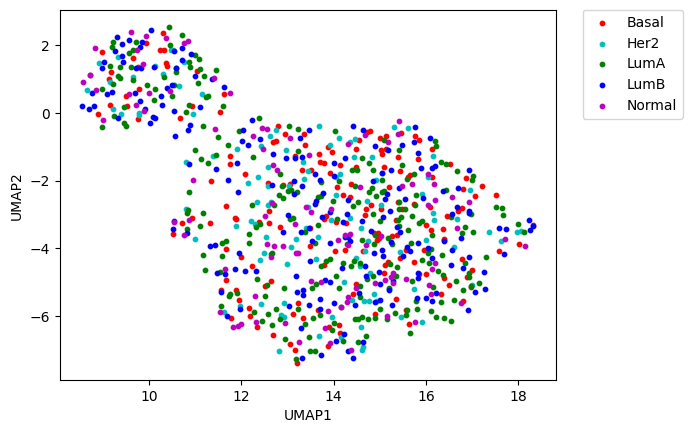

In [35]:
# Faire afficher dans un graphique (reprendre le même code qu'avant)
X_tr_umap_df = pd.DataFrame(X_tr_umap)

targets = list(np.unique(labels))
colors = ["r", "c", "g", "b", "m"]

plt.figure()
for target, color in zip(targets, colors):
    indexToKeep = count_df["labels"] == target # Utiliser Y_train 
    plt.scatter(X_tr_umap_df.loc[indexToKeep, 0], X_tr_umap_df.loc[indexToKeep, 1], 
                color = color, s = 10)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(targets, loc = "upper left", bbox_to_anchor=(1.04, 1.02))